# Project - Train an Image Classifier From Scratch
## Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt


# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

In [2]:
root_dir = r"/kaggle/input/open-cv-py-torch-project-1-classification-round-2/dataset"

train_dir = os.path.join(root_dir, "Train")
valid_dir = os.path.join(root_dir, "Valid")

In [3]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * (level)
        print(f"{indent}{os.path.basename(root):<8}")


list_folders(root_dir)

dataset 
    Valid   
        dog     
        panda   
        cat     
    Test    
    Train   
        dog     
        panda   
        cat     


In [4]:
from torchvision import datasets

In [5]:
train_data = datasets.ImageFolder(train_dir)
validation_data = datasets.ImageFolder(valid_dir)

In [6]:
print(train_data.classes)
print(validation_data.classes)

['cat', 'dog', 'panda']
['cat', 'dog', 'panda']


In [7]:
print(train_data.class_to_idx)
print(validation_data.class_to_idx)

{'cat': 0, 'dog': 1, 'panda': 2}
{'cat': 0, 'dog': 1, 'panda': 2}


In [8]:
print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))

Training samples: 2100
Validation samples: 300


image size: (500, 374), target: 0


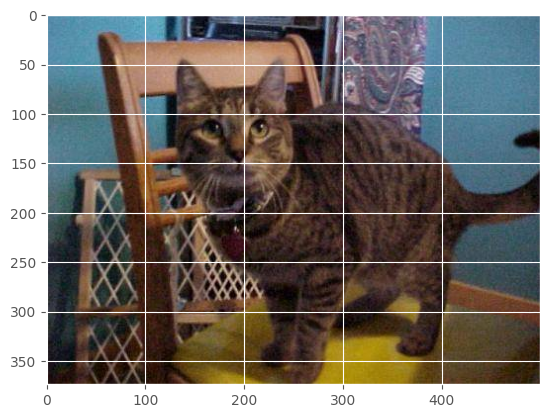

In [9]:
from PIL import Image

img, target = train_data[0]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

image size: (382, 478), target: 1


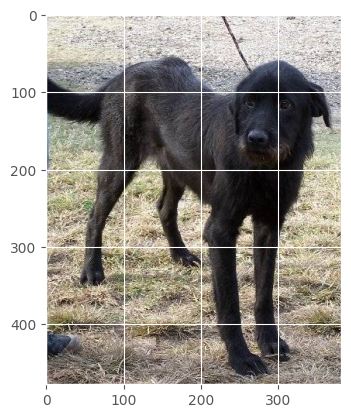

In [10]:
img, target = train_data[700]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

image size: (480, 500), target: 2


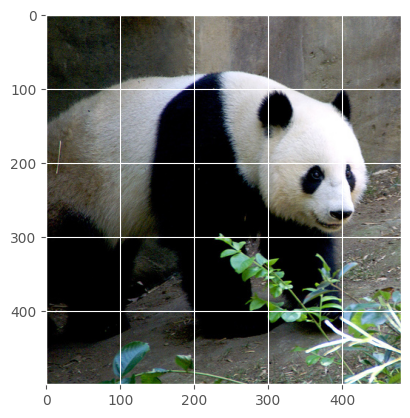

In [11]:
img, target = train_data[1400]

print("image size: {}, target: {}".format(img.size, target))

plt.imshow(img)
plt.show()

In [12]:
import torch
import numpy as np

In [13]:
subset_size = 0.05

In [14]:
train_subset = torch.utils.data.Subset(train_data, np.arange(0, len(train_data), 1.0 / subset_size))

validation_subset = torch.utils.data.Subset(validation_data, np.arange(0, len(validation_data), 1.0 / subset_size))

In [15]:
train_subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=8, num_workers=1, shuffle=False)

validation_subset_loader = torch.utils.data.DataLoader(validation_subset, batch_size=8, num_workers=1, shuffle=False)

In [16]:
print("Train Subset Size: {}".format(len(train_subset_loader.dataset)))
print("Validation Subset Size: {}".format(len(validation_subset_loader.dataset)))

Train Subset Size: 105
Validation Subset Size: 15


In [17]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy



# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

## Preprocessing Transforms

In [18]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess


## Common Image Transforms

In [19]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

## Mean and STD

In [20]:
def get_mean_std(data_root, img_size=(224, 224), num_workers=4):
    transform = image_preprocess_transforms(img_size=img_size)

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

## Data Loaders 

Data loader for generating batches of data to be used by the training routine

In [21]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )

    return loader

## Prepare Data
The main function which uses all the above functions to generate the train and valid dataloaders.


In [22]:
def get_data(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")

    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)

    common_transforms = image_common_transforms(img_size, mean, std)

    # If data_augmentation is true data augmentation will be applied.
    if data_augmentation:
        train_transforms = data_augmentation_preprocess(mean, std)
    # Else simply do common transforms
    else:
        train_transforms = common_transforms

    # Train dataloader
    train_loader = data_loader(
        train_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    # Valid dataloader
    valid_data_path = os.path.join(data_root, "Valid")

    valid_loader = data_loader(
        valid_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader


# Train The Model

Now, create the training pipeline, and train the model on the full data.
### System Configuration

In [23]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 21  # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # Enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # Make cudnn deterministic (reproducible training)

### Training Configuration

In [24]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 3
    batch_size: int = 8
    img_size: Tuple = (200, 200)
    epochs_count: int = 120
    init_learning_rate: float = 0.001  # Initial learning rate
    data_root: str = "/kaggle/input/open-cv-py-torch-project-1-classification-round-2/dataset"
    num_workers: int = 2
    device: str = "cuda"

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "cat_dog_panda_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

### System Setup

In [25]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## Training Function

In the next code cell, we are going to define the training function, which is a crucial step in our deep learning pipeline. This function will handle the processes involved in training, including feeding data to the model, adjusting weights, and optimizing performance.

In [26]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    
    # Change model in training mode.
    model.train()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(train_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Batch Loss.
        mean_metric(loss.item(), weight=data.shape[0])

        # # Get probability score using softmax.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Train Loss: {mean_metric.compute():.4f}, Train Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = mean_metric.compute()
    epoch_acc = acc_metric.compute()

    prog_bar.close()

    return epoch_loss, epoch_acc

## Validation Function

In the upcoming code cell, we will create the validation function. This function is essential for assessing the performance of our model on unseen data, ensuring its effectiveness and accuracy.

In [27]:
def validate(
    train_config: TrainingConfig, 
    model: nn.Module, 
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int, 
    total_epochs: int,
    scheduler=None
) -> Tuple[float, float]:

    # Change model in evaluation mode.
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(valid_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        valid_loss = F.cross_entropy(output, target).item()

        # Batch validation loss.
        mean_metric(valid_loss, weight=data.shape[0])

        # # Convert model's logits to probability scores.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Valid Loss: {mean_metric.compute():.4f}, Valid Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    valid_loss = mean_metric.compute()
    valid_acc = acc_metric.compute()

    prog_bar.close()

    if scheduler is not None:
        scheduler.step(valid_loss)
        for param_group in scheduler.optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Learning rate adjusted to: {current_lr:.6f}")

    return valid_loss, valid_acc

## Save & Load Model

The following two code cells are dedicated to essential functions in deep learning model management:

1. **Saving the Model Function**: This function is crucial for preserving the trained model state, allowing us to store the learned parameters for future use or further analysis.

2. **Loading the Model Function**: This function is designed to retrieve and load a previously saved model. It's vital for resuming training, making predictions, or conducting evaluations without having to retrain the model from scratch.


In [28]:
def save_model(model, device, model_dir="models", model_file_name="cat_dog_panda_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [29]:
def load_model(model, model_dir="models", model_file_name="cat_dog_panda_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

## Logging Setup

This function will be initializing directories so that they save tensorboard and model checkpoints for different training versions.


In [30]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

## Plot Loss and Accuracy

The next code cell will focus on developing a function for plotting loss and accuracy graphs. This function is instrumental in visualizing the performance of the deep learning model throughout the training process, providing insights into its learning behavior by displaying trends in loss reduction and accuracy improvement over epochs.


In [31]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

## Main Function for Training

In this function, we integrate all the various functions we've previously defined, creating a cohesive and streamlined workflow.

In [32]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):
    
    # Setup system configuration.
    setup_system(system_config)

    # Initialize data loader
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
    )

    # Number of epochs to train.
    NUM_EPOCHS = training_config.epochs_count

    # Set acceleration device.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Send model to device (GPU/CPU)
    model.to(device)

    # Initialize Adam optimizer.
    # optimizer = optim.Adam(model.parameters(), lr=training_config.init_learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=training_config.init_learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

    best_loss = torch.tensor(np.inf)

    # Epoch train & valid loss accumulator.
    epoch_train_loss = []
    epoch_valid_loss = []

    # Epoch train & valid accuracy accumulator.
    epoch_train_acc = []
    epoch_valid_acc = []

    # Trainig time measurement
    t_begin = time.time()

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(training_config, model, optimizer, train_loader, epoch + 1, NUM_EPOCHS)
        val_loss, val_accuracy = validate(training_config, model, valid_loader, epoch + 1, NUM_EPOCHS)

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_valid_loss.append(val_loss)
        epoch_valid_acc.append(val_accuracy)

        summary_writer.add_scalar("Loss/Train", train_loss, epoch)
        summary_writer.add_scalar("Accuracy/Train", train_acc, epoch)

        summary_writer.add_scalar("Loss/Validation", val_loss, epoch)
        summary_writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            torch.save(model.state_dict(), os.path.join(training_config.checkpoint_dir, training_config.save_model_name))
            print("Done.\n")

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

## Define Model

**Next, define the CNN model.**

Keep iterating. Do this by training various models.

Experiment by changing the:

* Number of layers.
* Number of filters/units per layer.
* Different types of layers, e.g., dropout, batch normalization.
* Different combination of layers.

In [33]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self._body = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self._head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)
        )


    def forward(self, x):
        x = self._body(x)
        x = self._head(x)
        return x

## Training


In [34]:
model = MyModel()
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(5

In [35]:
# Train and Validate
train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    scheduler=None,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
)

mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2681, 0.2595, 0.2594])


Train:	Epoch: 1/120 Train Loss: 0.8968, Train Acc: 0.5405: 100%|██████████| 263/263 [00:08<00:00, 29.41it/s]
Valid:	Epoch: 1/120 Valid Loss: 0.8253, Valid Acc: 0.5833: 100%|██████████| 38/38 [00:01<00:00, 24.47it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/120 Train Loss: 0.8400, Train Acc: 0.5648: 100%|██████████| 263/263 [00:07<00:00, 33.43it/s]
Valid:	Epoch: 2/120 Valid Loss: 0.8638, Valid Acc: 0.5667: 100%|██████████| 38/38 [00:00<00:00, 40.98it/s]


Train:	Epoch: 3/120 Train Loss: 0.8186, Train Acc: 0.5767: 100%|██████████| 263/263 [00:07<00:00, 33.49it/s]
Valid:	Epoch: 3/120 Valid Loss: 0.7968, Valid Acc: 0.6333: 100%|██████████| 38/38 [00:00<00:00, 40.23it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 4/120 Train Loss: 0.8035, Train Acc: 0.5810: 100%|██████████| 263/263 [00:07<00:00, 33.46it/s]
Valid:	Epoch: 4/120 Valid Loss: 0.7394, Valid Acc: 0.6600: 100%|██████████| 38/38 [00:00<00:00, 40.45it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 5/120 Train Loss: 0.7848, Train Acc: 0.6071: 100%|██████████| 263/263 [00:07<00:00, 33.47it/s]
Valid:	Epoch: 5/120 Valid Loss: 0.8200, Valid Acc: 0.6100: 100%|██████████| 38/38 [00:00<00:00, 42.00it/s]


Train:	Epoch: 6/120 Train Loss: 0.7661, Train Acc: 0.5938: 100%|██████████| 263/263 [00:07<00:00, 33.55it/s]
Valid:	Epoch: 6/120 Valid Loss: 0.7722, Valid Acc: 0.6300: 100%|██████████| 38/38 [00:00<00:00, 39.07it/s]


Train:	Epoch: 7/120 Train Loss: 0.7853, Train Acc: 0.6143: 100%|██████████| 263/263 [00:07<00:00, 33.48it/s]
Valid:	Epoch: 7/120 Valid Loss: 0.8479, Valid Acc: 0.5800: 100%|██████████| 38/38 [00:00<00:00, 39.88it/s]


Train:	Epoch: 8/120 Train Loss: 0.7634, Train Acc: 0.6110: 100%|██████████| 263/263 [00:07<00:00, 33.38it/s]
Valid:	Epoch: 8/120 Valid Loss: 0.7042, Valid Acc: 0.6500: 100%|██████████| 38/38 [00:00<00:00, 42.31it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 9/120 Train Loss: 0.7301, Train Acc: 0.6305: 100%|██████████| 263/263 [00:07<00:00, 33.47it/s]
Valid:	Epoch: 9/120 Valid Loss: 0.8809, Valid Acc: 0.6200: 100%|██████████| 38/38 [00:00<00:00, 40.87it/s]


Train:	Epoch: 10/120 Train Loss: 0.7229, Train Acc: 0.6376: 100%|██████████| 263/263 [00:07<00:00, 33.46it/s]
Valid:	Epoch: 10/120 Valid Loss: 0.8596, Valid Acc: 0.5733: 100%|██████████| 38/38 [00:00<00:00, 40.31it/s]


Train:	Epoch: 11/120 Train Loss: 0.7320, Train Acc: 0.6257: 100%|██████████| 263/263 [00:07<00:00, 33.45it/s]
Valid:	Epoch: 11/120 Valid Loss: 0.7164, Valid Acc: 0.6633: 100%|██████████| 38/38 [00:00<00:00, 38.96it/s]


Train:	Epoch: 12/120 Train Loss: 0.7168, Train Acc: 0.6529: 100%|██████████| 263/263 [00:07<00:00, 33.43it/s]
Valid:	Epoch: 12/120 Valid Loss: 0.7606, Valid Acc: 0.6233: 100%|██████████| 38/38 [00:00<00:00, 40.34it/s]


Train:	Epoch: 13/120 Train Loss: 0.7399, Train Acc: 0.6448: 100%|██████████| 263/263 [00:07<00:00, 33.41it/s]
Valid:	Epoch: 13/120 Valid Loss: 0.7546, Valid Acc: 0.6367: 100%|██████████| 38/38 [00:00<00:00, 38.74it/s]


Train:	Epoch: 14/120 Train Loss: 0.6936, Train Acc: 0.6571: 100%|██████████| 263/263 [00:07<00:00, 33.30it/s]
Valid:	Epoch: 14/120 Valid Loss: 0.6334, Valid Acc: 0.6900: 100%|██████████| 38/38 [00:00<00:00, 39.26it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 15/120 Train Loss: 0.6819, Train Acc: 0.6700: 100%|██████████| 263/263 [00:07<00:00, 33.33it/s]
Valid:	Epoch: 15/120 Valid Loss: 0.7280, Valid Acc: 0.6200: 100%|██████████| 38/38 [00:01<00:00, 37.83it/s]


Train:	Epoch: 16/120 Train Loss: 0.6993, Train Acc: 0.6538: 100%|██████████| 263/263 [00:07<00:00, 33.50it/s]
Valid:	Epoch: 16/120 Valid Loss: 0.7114, Valid Acc: 0.6933: 100%|██████████| 38/38 [00:00<00:00, 40.48it/s]


Train:	Epoch: 17/120 Train Loss: 0.6874, Train Acc: 0.6681: 100%|██████████| 263/263 [00:07<00:00, 33.49it/s]
Valid:	Epoch: 17/120 Valid Loss: 0.8735, Valid Acc: 0.6433: 100%|██████████| 38/38 [00:00<00:00, 40.56it/s]


Train:	Epoch: 18/120 Train Loss: 0.6616, Train Acc: 0.6829: 100%|██████████| 263/263 [00:07<00:00, 33.38it/s]
Valid:	Epoch: 18/120 Valid Loss: 0.6454, Valid Acc: 0.6933: 100%|██████████| 38/38 [00:00<00:00, 39.86it/s]


Train:	Epoch: 19/120 Train Loss: 0.6485, Train Acc: 0.6876: 100%|██████████| 263/263 [00:07<00:00, 33.43it/s]
Valid:	Epoch: 19/120 Valid Loss: 0.5608, Valid Acc: 0.7433: 100%|██████████| 38/38 [00:00<00:00, 39.72it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 20/120 Train Loss: 0.6572, Train Acc: 0.6605: 100%|██████████| 263/263 [00:07<00:00, 33.36it/s]
Valid:	Epoch: 20/120 Valid Loss: 0.6787, Valid Acc: 0.6733: 100%|██████████| 38/38 [00:00<00:00, 39.83it/s]


Train:	Epoch: 21/120 Train Loss: 0.6335, Train Acc: 0.6886: 100%|██████████| 263/263 [00:07<00:00, 33.42it/s]
Valid:	Epoch: 21/120 Valid Loss: 0.5131, Valid Acc: 0.7433: 100%|██████████| 38/38 [00:00<00:00, 38.07it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 22/120 Train Loss: 0.6476, Train Acc: 0.7033: 100%|██████████| 263/263 [00:07<00:00, 33.31it/s]
Valid:	Epoch: 22/120 Valid Loss: 0.9826, Valid Acc: 0.5833: 100%|██████████| 38/38 [00:00<00:00, 39.78it/s]


Train:	Epoch: 23/120 Train Loss: 0.6163, Train Acc: 0.7033: 100%|██████████| 263/263 [00:07<00:00, 33.36it/s]
Valid:	Epoch: 23/120 Valid Loss: 0.8176, Valid Acc: 0.6500: 100%|██████████| 38/38 [00:00<00:00, 39.45it/s]


Train:	Epoch: 24/120 Train Loss: 0.6556, Train Acc: 0.6743: 100%|██████████| 263/263 [00:07<00:00, 33.31it/s]
Valid:	Epoch: 24/120 Valid Loss: 0.5737, Valid Acc: 0.7267: 100%|██████████| 38/38 [00:00<00:00, 40.35it/s]


Train:	Epoch: 25/120 Train Loss: 0.6087, Train Acc: 0.7019: 100%|██████████| 263/263 [00:07<00:00, 33.37it/s]
Valid:	Epoch: 25/120 Valid Loss: 0.6161, Valid Acc: 0.7300: 100%|██████████| 38/38 [00:00<00:00, 39.60it/s]


Train:	Epoch: 26/120 Train Loss: 0.6556, Train Acc: 0.6833: 100%|██████████| 263/263 [00:07<00:00, 33.26it/s]
Valid:	Epoch: 26/120 Valid Loss: 0.8023, Valid Acc: 0.6300: 100%|██████████| 38/38 [00:00<00:00, 40.13it/s]


Train:	Epoch: 27/120 Train Loss: 0.5952, Train Acc: 0.7162: 100%|██████████| 263/263 [00:07<00:00, 33.41it/s]
Valid:	Epoch: 27/120 Valid Loss: 0.8854, Valid Acc: 0.5633: 100%|██████████| 38/38 [00:00<00:00, 39.06it/s]


Train:	Epoch: 28/120 Train Loss: 0.6122, Train Acc: 0.7057: 100%|██████████| 263/263 [00:07<00:00, 33.37it/s]
Valid:	Epoch: 28/120 Valid Loss: 1.6007, Valid Acc: 0.5300: 100%|██████████| 38/38 [00:00<00:00, 41.11it/s]


Train:	Epoch: 29/120 Train Loss: 0.5955, Train Acc: 0.7190: 100%|██████████| 263/263 [00:07<00:00, 32.99it/s]
Valid:	Epoch: 29/120 Valid Loss: 0.8954, Valid Acc: 0.6500: 100%|██████████| 38/38 [00:01<00:00, 36.06it/s]


Train:	Epoch: 30/120 Train Loss: 0.6089, Train Acc: 0.7176: 100%|██████████| 263/263 [00:08<00:00, 32.29it/s]
Valid:	Epoch: 30/120 Valid Loss: 0.6285, Valid Acc: 0.6967: 100%|██████████| 38/38 [00:00<00:00, 39.07it/s]


Train:	Epoch: 31/120 Train Loss: 0.5932, Train Acc: 0.7200: 100%|██████████| 263/263 [00:07<00:00, 33.01it/s]
Valid:	Epoch: 31/120 Valid Loss: 0.6327, Valid Acc: 0.7100: 100%|██████████| 38/38 [00:00<00:00, 39.48it/s]


Train:	Epoch: 32/120 Train Loss: 0.5873, Train Acc: 0.7271: 100%|██████████| 263/263 [00:07<00:00, 33.06it/s]
Valid:	Epoch: 32/120 Valid Loss: 0.8574, Valid Acc: 0.6433: 100%|██████████| 38/38 [00:00<00:00, 40.01it/s]


Train:	Epoch: 33/120 Train Loss: 0.6077, Train Acc: 0.6952: 100%|██████████| 263/263 [00:08<00:00, 32.74it/s]
Valid:	Epoch: 33/120 Valid Loss: 0.6925, Valid Acc: 0.6700: 100%|██████████| 38/38 [00:01<00:00, 36.86it/s]


Train:	Epoch: 34/120 Train Loss: 0.5697, Train Acc: 0.7305: 100%|██████████| 263/263 [00:08<00:00, 32.51it/s]
Valid:	Epoch: 34/120 Valid Loss: 0.8911, Valid Acc: 0.5800: 100%|██████████| 38/38 [00:01<00:00, 35.83it/s]


Train:	Epoch: 35/120 Train Loss: 0.5785, Train Acc: 0.7271: 100%|██████████| 263/263 [00:08<00:00, 31.05it/s]
Valid:	Epoch: 35/120 Valid Loss: 0.5817, Valid Acc: 0.7333: 100%|██████████| 38/38 [00:01<00:00, 36.48it/s]


Train:	Epoch: 36/120 Train Loss: 0.5577, Train Acc: 0.7419: 100%|██████████| 263/263 [00:08<00:00, 31.77it/s]
Valid:	Epoch: 36/120 Valid Loss: 0.7602, Valid Acc: 0.6800: 100%|██████████| 38/38 [00:00<00:00, 38.63it/s]


Train:	Epoch: 37/120 Train Loss: 0.5486, Train Acc: 0.7562: 100%|██████████| 263/263 [00:08<00:00, 32.23it/s]
Valid:	Epoch: 37/120 Valid Loss: 1.2143, Valid Acc: 0.5367: 100%|██████████| 38/38 [00:00<00:00, 38.76it/s]


Train:	Epoch: 38/120 Train Loss: 0.5638, Train Acc: 0.7338: 100%|██████████| 263/263 [00:08<00:00, 32.31it/s]
Valid:	Epoch: 38/120 Valid Loss: 0.8231, Valid Acc: 0.6700: 100%|██████████| 38/38 [00:00<00:00, 39.46it/s]


Train:	Epoch: 39/120 Train Loss: 0.5502, Train Acc: 0.7533: 100%|██████████| 263/263 [00:08<00:00, 32.65it/s]
Valid:	Epoch: 39/120 Valid Loss: 0.7380, Valid Acc: 0.6600: 100%|██████████| 38/38 [00:00<00:00, 38.72it/s]


Train:	Epoch: 40/120 Train Loss: 0.5534, Train Acc: 0.7395: 100%|██████████| 263/263 [00:08<00:00, 32.23it/s]
Valid:	Epoch: 40/120 Valid Loss: 1.0259, Valid Acc: 0.6300: 100%|██████████| 38/38 [00:01<00:00, 37.93it/s]


Train:	Epoch: 41/120 Train Loss: 0.5601, Train Acc: 0.7438: 100%|██████████| 263/263 [00:08<00:00, 32.29it/s]
Valid:	Epoch: 41/120 Valid Loss: 1.0408, Valid Acc: 0.6067: 100%|██████████| 38/38 [00:01<00:00, 34.01it/s]


Train:	Epoch: 42/120 Train Loss: 0.5488, Train Acc: 0.7500: 100%|██████████| 263/263 [00:08<00:00, 32.08it/s]
Valid:	Epoch: 42/120 Valid Loss: 0.5108, Valid Acc: 0.7733: 100%|██████████| 38/38 [00:01<00:00, 36.21it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 43/120 Train Loss: 0.5349, Train Acc: 0.7438: 100%|██████████| 263/263 [00:08<00:00, 31.73it/s]
Valid:	Epoch: 43/120 Valid Loss: 0.5221, Valid Acc: 0.7600: 100%|██████████| 38/38 [00:01<00:00, 36.73it/s]


Train:	Epoch: 44/120 Train Loss: 0.5411, Train Acc: 0.7433: 100%|██████████| 263/263 [00:08<00:00, 32.00it/s]
Valid:	Epoch: 44/120 Valid Loss: 0.7979, Valid Acc: 0.6500: 100%|██████████| 38/38 [00:01<00:00, 37.27it/s]


Train:	Epoch: 45/120 Train Loss: 0.5538, Train Acc: 0.7348: 100%|██████████| 263/263 [00:08<00:00, 32.01it/s]
Valid:	Epoch: 45/120 Valid Loss: 0.5866, Valid Acc: 0.7633: 100%|██████████| 38/38 [00:01<00:00, 35.36it/s]


Train:	Epoch: 46/120 Train Loss: 0.5351, Train Acc: 0.7414: 100%|██████████| 263/263 [00:08<00:00, 32.21it/s]
Valid:	Epoch: 46/120 Valid Loss: 0.6625, Valid Acc: 0.7067: 100%|██████████| 38/38 [00:01<00:00, 35.58it/s]


Train:	Epoch: 47/120 Train Loss: 0.5170, Train Acc: 0.7514: 100%|██████████| 263/263 [00:08<00:00, 31.96it/s]
Valid:	Epoch: 47/120 Valid Loss: 0.7481, Valid Acc: 0.6867: 100%|██████████| 38/38 [00:01<00:00, 34.13it/s]


Train:	Epoch: 48/120 Train Loss: 0.4925, Train Acc: 0.7771: 100%|██████████| 263/263 [00:08<00:00, 31.92it/s]
Valid:	Epoch: 48/120 Valid Loss: 0.5501, Valid Acc: 0.7733: 100%|██████████| 38/38 [00:01<00:00, 37.33it/s]


Train:	Epoch: 49/120 Train Loss: 0.5326, Train Acc: 0.7657: 100%|██████████| 263/263 [00:08<00:00, 32.01it/s]
Valid:	Epoch: 49/120 Valid Loss: 0.5290, Valid Acc: 0.7867: 100%|██████████| 38/38 [00:01<00:00, 36.40it/s]


Train:	Epoch: 50/120 Train Loss: 0.5289, Train Acc: 0.7519: 100%|██████████| 263/263 [00:08<00:00, 31.75it/s]
Valid:	Epoch: 50/120 Valid Loss: 0.9092, Valid Acc: 0.6533: 100%|██████████| 38/38 [00:01<00:00, 36.29it/s]


Train:	Epoch: 51/120 Train Loss: 0.5024, Train Acc: 0.7710: 100%|██████████| 263/263 [00:08<00:00, 31.60it/s]
Valid:	Epoch: 51/120 Valid Loss: 0.5438, Valid Acc: 0.7333: 100%|██████████| 38/38 [00:01<00:00, 36.56it/s]


Train:	Epoch: 52/120 Train Loss: 0.4917, Train Acc: 0.7829: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 52/120 Valid Loss: 0.5241, Valid Acc: 0.7600: 100%|██████████| 38/38 [00:00<00:00, 38.26it/s]


Train:	Epoch: 53/120 Train Loss: 0.4888, Train Acc: 0.7795: 100%|██████████| 263/263 [00:08<00:00, 32.18it/s]
Valid:	Epoch: 53/120 Valid Loss: 0.5822, Valid Acc: 0.7633: 100%|██████████| 38/38 [00:01<00:00, 36.80it/s]


Train:	Epoch: 54/120 Train Loss: 0.5160, Train Acc: 0.7662: 100%|██████████| 263/263 [00:08<00:00, 32.19it/s]
Valid:	Epoch: 54/120 Valid Loss: 0.4436, Valid Acc: 0.7900: 100%|██████████| 38/38 [00:00<00:00, 39.99it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 55/120 Train Loss: 0.4979, Train Acc: 0.7667: 100%|██████████| 263/263 [00:08<00:00, 32.37it/s]
Valid:	Epoch: 55/120 Valid Loss: 0.4799, Valid Acc: 0.7833: 100%|██████████| 38/38 [00:01<00:00, 36.92it/s]


Train:	Epoch: 56/120 Train Loss: 0.4983, Train Acc: 0.7705: 100%|██████████| 263/263 [00:08<00:00, 32.68it/s]
Valid:	Epoch: 56/120 Valid Loss: 0.6141, Valid Acc: 0.6800: 100%|██████████| 38/38 [00:01<00:00, 37.37it/s]


Train:	Epoch: 57/120 Train Loss: 0.4833, Train Acc: 0.7843: 100%|██████████| 263/263 [00:08<00:00, 32.40it/s]
Valid:	Epoch: 57/120 Valid Loss: 0.4859, Valid Acc: 0.7567: 100%|██████████| 38/38 [00:00<00:00, 38.63it/s]


Train:	Epoch: 58/120 Train Loss: 0.4850, Train Acc: 0.7814: 100%|██████████| 263/263 [00:08<00:00, 32.36it/s]
Valid:	Epoch: 58/120 Valid Loss: 0.5288, Valid Acc: 0.7667: 100%|██████████| 38/38 [00:01<00:00, 37.75it/s]


Train:	Epoch: 59/120 Train Loss: 0.4989, Train Acc: 0.7762: 100%|██████████| 263/263 [00:08<00:00, 32.52it/s]
Valid:	Epoch: 59/120 Valid Loss: 0.5023, Valid Acc: 0.7900: 100%|██████████| 38/38 [00:01<00:00, 37.99it/s]


Train:	Epoch: 60/120 Train Loss: 0.4894, Train Acc: 0.7852: 100%|██████████| 263/263 [00:08<00:00, 32.23it/s]
Valid:	Epoch: 60/120 Valid Loss: 0.7006, Valid Acc: 0.6833: 100%|██████████| 38/38 [00:00<00:00, 38.06it/s]


Train:	Epoch: 61/120 Train Loss: 0.4749, Train Acc: 0.7833: 100%|██████████| 263/263 [00:08<00:00, 32.24it/s]
Valid:	Epoch: 61/120 Valid Loss: 0.5807, Valid Acc: 0.7200: 100%|██████████| 38/38 [00:00<00:00, 38.50it/s]


Train:	Epoch: 62/120 Train Loss: 0.4369, Train Acc: 0.7933: 100%|██████████| 263/263 [00:08<00:00, 32.29it/s]
Valid:	Epoch: 62/120 Valid Loss: 0.6042, Valid Acc: 0.7400: 100%|██████████| 38/38 [00:01<00:00, 35.93it/s]


Train:	Epoch: 63/120 Train Loss: 0.4659, Train Acc: 0.8010: 100%|██████████| 263/263 [00:08<00:00, 31.77it/s]
Valid:	Epoch: 63/120 Valid Loss: 0.9252, Valid Acc: 0.6633: 100%|██████████| 38/38 [00:01<00:00, 35.12it/s]


Train:	Epoch: 64/120 Train Loss: 0.4540, Train Acc: 0.7976: 100%|██████████| 263/263 [00:08<00:00, 31.97it/s]
Valid:	Epoch: 64/120 Valid Loss: 0.5318, Valid Acc: 0.7600: 100%|██████████| 38/38 [00:01<00:00, 37.64it/s]


Train:	Epoch: 65/120 Train Loss: 0.4536, Train Acc: 0.7910: 100%|██████████| 263/263 [00:08<00:00, 32.17it/s]
Valid:	Epoch: 65/120 Valid Loss: 0.6336, Valid Acc: 0.7167: 100%|██████████| 38/38 [00:00<00:00, 38.17it/s]


Train:	Epoch: 66/120 Train Loss: 0.4573, Train Acc: 0.7986: 100%|██████████| 263/263 [00:08<00:00, 31.85it/s]
Valid:	Epoch: 66/120 Valid Loss: 0.5454, Valid Acc: 0.7567: 100%|██████████| 38/38 [00:01<00:00, 37.00it/s]


Train:	Epoch: 67/120 Train Loss: 0.4575, Train Acc: 0.7971: 100%|██████████| 263/263 [00:08<00:00, 32.21it/s]
Valid:	Epoch: 67/120 Valid Loss: 0.4938, Valid Acc: 0.7833: 100%|██████████| 38/38 [00:01<00:00, 37.56it/s]


Train:	Epoch: 68/120 Train Loss: 0.4505, Train Acc: 0.8100: 100%|██████████| 263/263 [00:08<00:00, 32.37it/s]
Valid:	Epoch: 68/120 Valid Loss: 0.4993, Valid Acc: 0.7633: 100%|██████████| 38/38 [00:01<00:00, 37.81it/s]


Train:	Epoch: 69/120 Train Loss: 0.4495, Train Acc: 0.7957: 100%|██████████| 263/263 [00:08<00:00, 31.85it/s]
Valid:	Epoch: 69/120 Valid Loss: 0.8490, Valid Acc: 0.6033: 100%|██████████| 38/38 [00:01<00:00, 34.66it/s]


Train:	Epoch: 70/120 Train Loss: 0.4487, Train Acc: 0.8043: 100%|██████████| 263/263 [00:08<00:00, 32.19it/s]
Valid:	Epoch: 70/120 Valid Loss: 0.6894, Valid Acc: 0.7100: 100%|██████████| 38/38 [00:01<00:00, 37.98it/s]


Train:	Epoch: 71/120 Train Loss: 0.4214, Train Acc: 0.8205: 100%|██████████| 263/263 [00:08<00:00, 32.68it/s]
Valid:	Epoch: 71/120 Valid Loss: 0.4802, Valid Acc: 0.8067: 100%|██████████| 38/38 [00:01<00:00, 37.07it/s]


Train:	Epoch: 72/120 Train Loss: 0.4381, Train Acc: 0.8157: 100%|██████████| 263/263 [00:08<00:00, 32.16it/s]
Valid:	Epoch: 72/120 Valid Loss: 0.6747, Valid Acc: 0.7367: 100%|██████████| 38/38 [00:01<00:00, 35.60it/s]


Train:	Epoch: 73/120 Train Loss: 0.4308, Train Acc: 0.8138: 100%|██████████| 263/263 [00:08<00:00, 32.01it/s]
Valid:	Epoch: 73/120 Valid Loss: 0.5792, Valid Acc: 0.7567: 100%|██████████| 38/38 [00:00<00:00, 38.52it/s]


Train:	Epoch: 74/120 Train Loss: 0.4038, Train Acc: 0.8276: 100%|██████████| 263/263 [00:08<00:00, 32.18it/s]
Valid:	Epoch: 74/120 Valid Loss: 0.5005, Valid Acc: 0.7900: 100%|██████████| 38/38 [00:01<00:00, 37.33it/s]


Train:	Epoch: 75/120 Train Loss: 0.4219, Train Acc: 0.8090: 100%|██████████| 263/263 [00:08<00:00, 32.17it/s]
Valid:	Epoch: 75/120 Valid Loss: 0.4632, Valid Acc: 0.7600: 100%|██████████| 38/38 [00:01<00:00, 36.61it/s]


Train:	Epoch: 76/120 Train Loss: 0.3839, Train Acc: 0.8386: 100%|██████████| 263/263 [00:08<00:00, 32.20it/s]
Valid:	Epoch: 76/120 Valid Loss: 0.5494, Valid Acc: 0.7900: 100%|██████████| 38/38 [00:01<00:00, 35.06it/s]


Train:	Epoch: 77/120 Train Loss: 0.3989, Train Acc: 0.8333: 100%|██████████| 263/263 [00:08<00:00, 32.01it/s]
Valid:	Epoch: 77/120 Valid Loss: 0.5505, Valid Acc: 0.8133: 100%|██████████| 38/38 [00:01<00:00, 37.81it/s]


Train:	Epoch: 78/120 Train Loss: 0.3706, Train Acc: 0.8419: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 78/120 Valid Loss: 0.6219, Valid Acc: 0.7733: 100%|██████████| 38/38 [00:01<00:00, 35.87it/s]


Train:	Epoch: 79/120 Train Loss: 0.3808, Train Acc: 0.8376: 100%|██████████| 263/263 [00:08<00:00, 32.09it/s]
Valid:	Epoch: 79/120 Valid Loss: 0.4632, Valid Acc: 0.8367: 100%|██████████| 38/38 [00:01<00:00, 35.61it/s]


Train:	Epoch: 80/120 Train Loss: 0.3876, Train Acc: 0.8419: 100%|██████████| 263/263 [00:08<00:00, 31.89it/s]
Valid:	Epoch: 80/120 Valid Loss: 0.5312, Valid Acc: 0.8133: 100%|██████████| 38/38 [00:01<00:00, 35.71it/s]


Train:	Epoch: 81/120 Train Loss: 0.3787, Train Acc: 0.8314: 100%|██████████| 263/263 [00:08<00:00, 32.06it/s]
Valid:	Epoch: 81/120 Valid Loss: 0.5944, Valid Acc: 0.7567: 100%|██████████| 38/38 [00:01<00:00, 35.89it/s]


Train:	Epoch: 82/120 Train Loss: 0.3935, Train Acc: 0.8343: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 82/120 Valid Loss: 0.5720, Valid Acc: 0.7500: 100%|██████████| 38/38 [00:01<00:00, 37.99it/s]


Train:	Epoch: 83/120 Train Loss: 0.3519, Train Acc: 0.8581: 100%|██████████| 263/263 [00:08<00:00, 31.97it/s]
Valid:	Epoch: 83/120 Valid Loss: 0.5121, Valid Acc: 0.7833: 100%|██████████| 38/38 [00:01<00:00, 37.67it/s]


Train:	Epoch: 84/120 Train Loss: 0.3386, Train Acc: 0.8633: 100%|██████████| 263/263 [00:08<00:00, 32.26it/s]
Valid:	Epoch: 84/120 Valid Loss: 0.4536, Valid Acc: 0.8200: 100%|██████████| 38/38 [00:01<00:00, 37.59it/s]


Train:	Epoch: 85/120 Train Loss: 0.3621, Train Acc: 0.8552: 100%|██████████| 263/263 [00:08<00:00, 32.31it/s]
Valid:	Epoch: 85/120 Valid Loss: 0.6382, Valid Acc: 0.7333: 100%|██████████| 38/38 [00:01<00:00, 37.11it/s]


Train:	Epoch: 86/120 Train Loss: 0.3577, Train Acc: 0.8552: 100%|██████████| 263/263 [00:08<00:00, 32.12it/s]
Valid:	Epoch: 86/120 Valid Loss: 0.4352, Valid Acc: 0.8300: 100%|██████████| 38/38 [00:01<00:00, 37.71it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 87/120 Train Loss: 0.3317, Train Acc: 0.8667: 100%|██████████| 263/263 [00:08<00:00, 32.04it/s]
Valid:	Epoch: 87/120 Valid Loss: 0.4187, Valid Acc: 0.8233: 100%|██████████| 38/38 [00:01<00:00, 35.82it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 88/120 Train Loss: 0.3398, Train Acc: 0.8686: 100%|██████████| 263/263 [00:08<00:00, 32.02it/s]
Valid:	Epoch: 88/120 Valid Loss: 0.5895, Valid Acc: 0.7933: 100%|██████████| 38/38 [00:01<00:00, 37.05it/s]


Train:	Epoch: 89/120 Train Loss: 0.3287, Train Acc: 0.8652: 100%|██████████| 263/263 [00:08<00:00, 31.93it/s]
Valid:	Epoch: 89/120 Valid Loss: 0.4789, Valid Acc: 0.8067: 100%|██████████| 38/38 [00:01<00:00, 37.88it/s]


Train:	Epoch: 90/120 Train Loss: 0.3101, Train Acc: 0.8800: 100%|██████████| 263/263 [00:08<00:00, 31.86it/s]
Valid:	Epoch: 90/120 Valid Loss: 0.6087, Valid Acc: 0.7900: 100%|██████████| 38/38 [00:01<00:00, 37.06it/s]


Train:	Epoch: 91/120 Train Loss: 0.3242, Train Acc: 0.8729: 100%|██████████| 263/263 [00:08<00:00, 31.82it/s]
Valid:	Epoch: 91/120 Valid Loss: 0.6882, Valid Acc: 0.7467: 100%|██████████| 38/38 [00:01<00:00, 37.31it/s]


Train:	Epoch: 92/120 Train Loss: 0.2872, Train Acc: 0.8848: 100%|██████████| 263/263 [00:08<00:00, 31.74it/s]
Valid:	Epoch: 92/120 Valid Loss: 0.5871, Valid Acc: 0.7833: 100%|██████████| 38/38 [00:01<00:00, 37.89it/s]


Train:	Epoch: 93/120 Train Loss: 0.2914, Train Acc: 0.8867: 100%|██████████| 263/263 [00:08<00:00, 31.83it/s]
Valid:	Epoch: 93/120 Valid Loss: 0.4498, Valid Acc: 0.8500: 100%|██████████| 38/38 [00:01<00:00, 37.95it/s]


Train:	Epoch: 94/120 Train Loss: 0.3086, Train Acc: 0.8862: 100%|██████████| 263/263 [00:08<00:00, 31.92it/s]
Valid:	Epoch: 94/120 Valid Loss: 0.6039, Valid Acc: 0.7567: 100%|██████████| 38/38 [00:01<00:00, 37.27it/s]


Train:	Epoch: 95/120 Train Loss: 0.2962, Train Acc: 0.8767: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 95/120 Valid Loss: 0.4941, Valid Acc: 0.8267: 100%|██████████| 38/38 [00:00<00:00, 38.50it/s]


Train:	Epoch: 96/120 Train Loss: 0.2895, Train Acc: 0.8867: 100%|██████████| 263/263 [00:08<00:00, 31.97it/s]
Valid:	Epoch: 96/120 Valid Loss: 0.4180, Valid Acc: 0.8167: 100%|██████████| 38/38 [00:01<00:00, 37.08it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 97/120 Train Loss: 0.3222, Train Acc: 0.8738: 100%|██████████| 263/263 [00:08<00:00, 32.11it/s]
Valid:	Epoch: 97/120 Valid Loss: 0.4037, Valid Acc: 0.8200: 100%|██████████| 38/38 [00:00<00:00, 38.22it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 98/120 Train Loss: 0.2748, Train Acc: 0.8890: 100%|██████████| 263/263 [00:08<00:00, 32.20it/s]
Valid:	Epoch: 98/120 Valid Loss: 0.4791, Valid Acc: 0.8033: 100%|██████████| 38/38 [00:01<00:00, 37.41it/s]


Train:	Epoch: 99/120 Train Loss: 0.2818, Train Acc: 0.8952: 100%|██████████| 263/263 [00:08<00:00, 32.14it/s]
Valid:	Epoch: 99/120 Valid Loss: 0.3929, Valid Acc: 0.8333: 100%|██████████| 38/38 [00:01<00:00, 35.82it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 100/120 Train Loss: 0.2736, Train Acc: 0.8948: 100%|██████████| 263/263 [00:08<00:00, 31.95it/s]
Valid:	Epoch: 100/120 Valid Loss: 0.3494, Valid Acc: 0.8633: 100%|██████████| 38/38 [00:01<00:00, 36.36it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 101/120 Train Loss: 0.2482, Train Acc: 0.9057: 100%|██████████| 263/263 [00:08<00:00, 31.81it/s]
Valid:	Epoch: 101/120 Valid Loss: 0.4665, Valid Acc: 0.8267: 100%|██████████| 38/38 [00:01<00:00, 34.95it/s]


Train:	Epoch: 102/120 Train Loss: 0.2626, Train Acc: 0.9019: 100%|██████████| 263/263 [00:08<00:00, 31.79it/s]
Valid:	Epoch: 102/120 Valid Loss: 0.3796, Valid Acc: 0.8500: 100%|██████████| 38/38 [00:00<00:00, 38.03it/s]


Train:	Epoch: 103/120 Train Loss: 0.2567, Train Acc: 0.9081: 100%|██████████| 263/263 [00:08<00:00, 31.76it/s]
Valid:	Epoch: 103/120 Valid Loss: 0.6073, Valid Acc: 0.7833: 100%|██████████| 38/38 [00:00<00:00, 38.19it/s]


Train:	Epoch: 104/120 Train Loss: 0.2629, Train Acc: 0.9052: 100%|██████████| 263/263 [00:08<00:00, 31.94it/s]
Valid:	Epoch: 104/120 Valid Loss: 0.3674, Valid Acc: 0.8433: 100%|██████████| 38/38 [00:01<00:00, 36.37it/s]


Train:	Epoch: 105/120 Train Loss: 0.2330, Train Acc: 0.9152: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 105/120 Valid Loss: 0.3784, Valid Acc: 0.8400: 100%|██████████| 38/38 [00:01<00:00, 36.68it/s]


Train:	Epoch: 106/120 Train Loss: 0.2215, Train Acc: 0.9157: 100%|██████████| 263/263 [00:08<00:00, 32.06it/s]
Valid:	Epoch: 106/120 Valid Loss: 0.4779, Valid Acc: 0.8267: 100%|██████████| 38/38 [00:01<00:00, 36.73it/s]


Train:	Epoch: 107/120 Train Loss: 0.2544, Train Acc: 0.9014: 100%|██████████| 263/263 [00:08<00:00, 32.05it/s]
Valid:	Epoch: 107/120 Valid Loss: 0.4202, Valid Acc: 0.8067: 100%|██████████| 38/38 [00:01<00:00, 37.31it/s]


Train:	Epoch: 108/120 Train Loss: 0.2278, Train Acc: 0.9157: 100%|██████████| 263/263 [00:08<00:00, 32.07it/s]
Valid:	Epoch: 108/120 Valid Loss: 0.4268, Valid Acc: 0.8400: 100%|██████████| 38/38 [00:01<00:00, 37.66it/s]


Train:	Epoch: 109/120 Train Loss: 0.2142, Train Acc: 0.9176: 100%|██████████| 263/263 [00:08<00:00, 32.14it/s]
Valid:	Epoch: 109/120 Valid Loss: 0.4717, Valid Acc: 0.8300: 100%|██████████| 38/38 [00:01<00:00, 36.82it/s]


Train:	Epoch: 110/120 Train Loss: 0.2367, Train Acc: 0.9057: 100%|██████████| 263/263 [00:08<00:00, 32.04it/s]
Valid:	Epoch: 110/120 Valid Loss: 0.6183, Valid Acc: 0.8167: 100%|██████████| 38/38 [00:00<00:00, 38.32it/s]


Train:	Epoch: 111/120 Train Loss: 0.2243, Train Acc: 0.9157: 100%|██████████| 263/263 [00:08<00:00, 32.02it/s]
Valid:	Epoch: 111/120 Valid Loss: 0.4739, Valid Acc: 0.8000: 100%|██████████| 38/38 [00:00<00:00, 38.17it/s]


Train:	Epoch: 112/120 Train Loss: 0.1859, Train Acc: 0.9257: 100%|██████████| 263/263 [00:08<00:00, 32.13it/s]
Valid:	Epoch: 112/120 Valid Loss: 0.4078, Valid Acc: 0.8333: 100%|██████████| 38/38 [00:01<00:00, 35.36it/s]


Train:	Epoch: 113/120 Train Loss: 0.2111, Train Acc: 0.9181: 100%|██████████| 263/263 [00:08<00:00, 32.14it/s]
Valid:	Epoch: 113/120 Valid Loss: 0.4586, Valid Acc: 0.8433: 100%|██████████| 38/38 [00:01<00:00, 36.42it/s]


Train:	Epoch: 114/120 Train Loss: 0.1887, Train Acc: 0.9290: 100%|██████████| 263/263 [00:08<00:00, 32.21it/s]
Valid:	Epoch: 114/120 Valid Loss: 0.7865, Valid Acc: 0.7700: 100%|██████████| 38/38 [00:01<00:00, 37.95it/s]


Train:	Epoch: 115/120 Train Loss: 0.2220, Train Acc: 0.9176: 100%|██████████| 263/263 [00:08<00:00, 32.14it/s]
Valid:	Epoch: 115/120 Valid Loss: 0.4142, Valid Acc: 0.8633: 100%|██████████| 38/38 [00:01<00:00, 36.27it/s]


Train:	Epoch: 116/120 Train Loss: 0.1806, Train Acc: 0.9367: 100%|██████████| 263/263 [00:08<00:00, 32.01it/s]
Valid:	Epoch: 116/120 Valid Loss: 0.3693, Valid Acc: 0.8633: 100%|██████████| 38/38 [00:01<00:00, 36.52it/s]


Train:	Epoch: 117/120 Train Loss: 0.1870, Train Acc: 0.9319: 100%|██████████| 263/263 [00:08<00:00, 32.22it/s]
Valid:	Epoch: 117/120 Valid Loss: 0.4457, Valid Acc: 0.8500: 100%|██████████| 38/38 [00:00<00:00, 38.63it/s]


Train:	Epoch: 118/120 Train Loss: 0.2015, Train Acc: 0.9238: 100%|██████████| 263/263 [00:08<00:00, 32.14it/s]
Valid:	Epoch: 118/120 Valid Loss: 0.7198, Valid Acc: 0.7800: 100%|██████████| 38/38 [00:01<00:00, 35.48it/s]


Train:	Epoch: 119/120 Train Loss: 0.1960, Train Acc: 0.9276: 100%|██████████| 263/263 [00:08<00:00, 31.98it/s]
Valid:	Epoch: 119/120 Valid Loss: 0.5209, Valid Acc: 0.8200: 100%|██████████| 38/38 [00:00<00:00, 38.37it/s]


Train:	Epoch: 120/120 Train Loss: 0.1892, Train Acc: 0.9295: 100%|██████████| 263/263 [00:08<00:00, 32.02it/s]
Valid:	Epoch: 120/120 Valid Loss: 0.8923, Valid Acc: 0.7467: 100%|██████████| 38/38 [00:00<00:00, 38.39it/s]


Total time: 1098.07s, Best Loss: 0.349


## Loss and Accuracy Plot

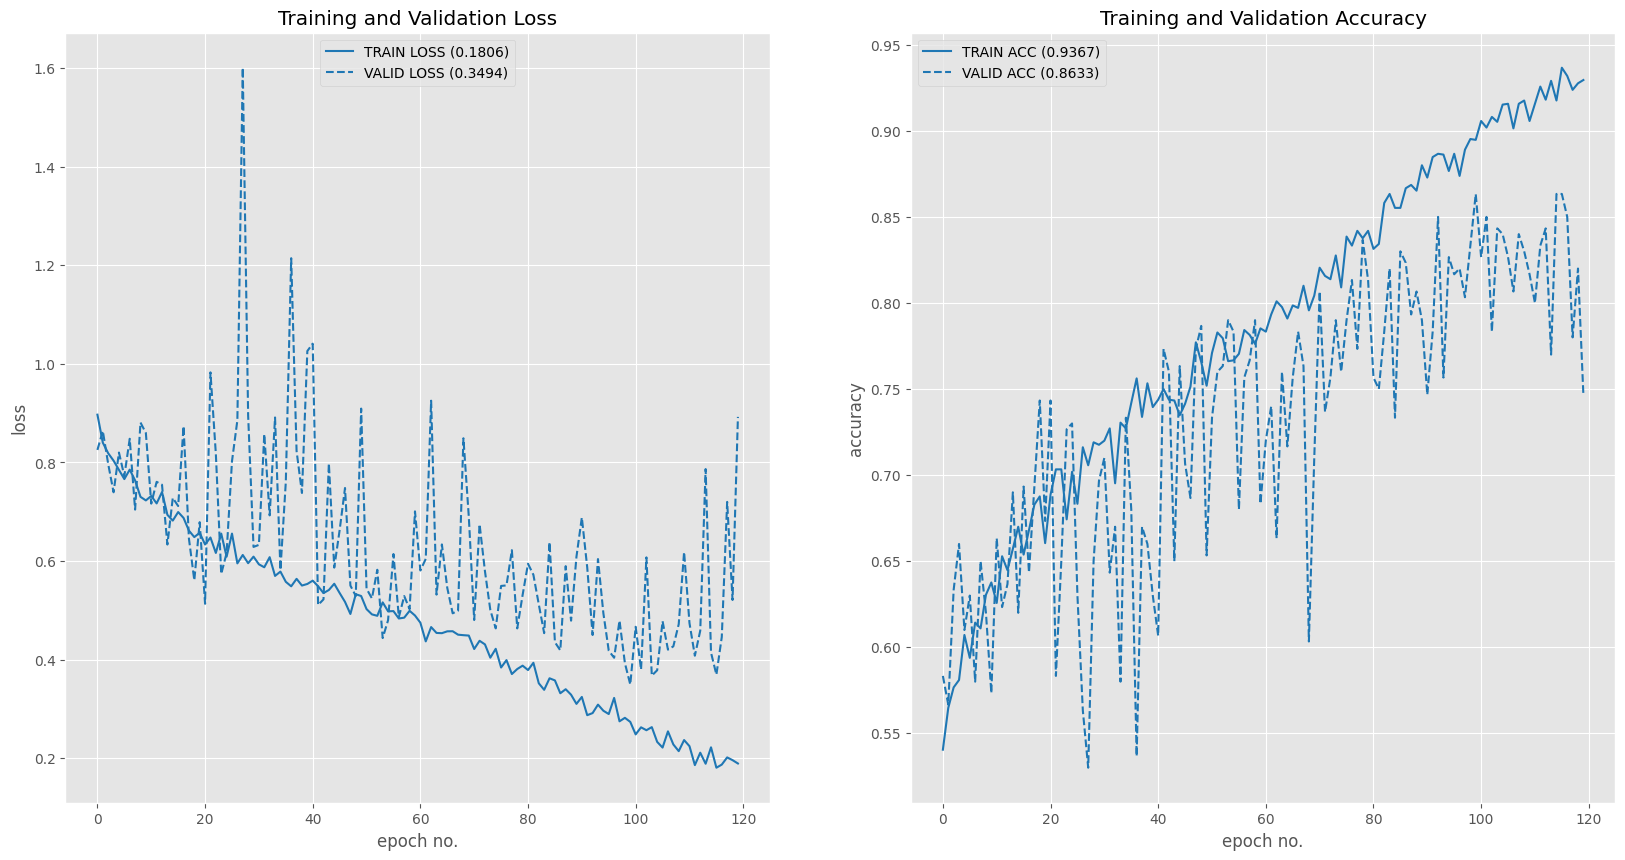

In [36]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# Sample Prediction

In [37]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## Get Predictions on a Batch

In [38]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return

## Load Model and Run Inference

Next, we will reload the best saved model and use the `get_sample_prediction` function to make some sample predictions. This step is instrumental in visually assessing the performance of our model on the validation dataset, providing a quick and practical insight into how well our model generalizes to new, unseen data.


<ipython-input-29-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2681, 0.2595, 0.2594])


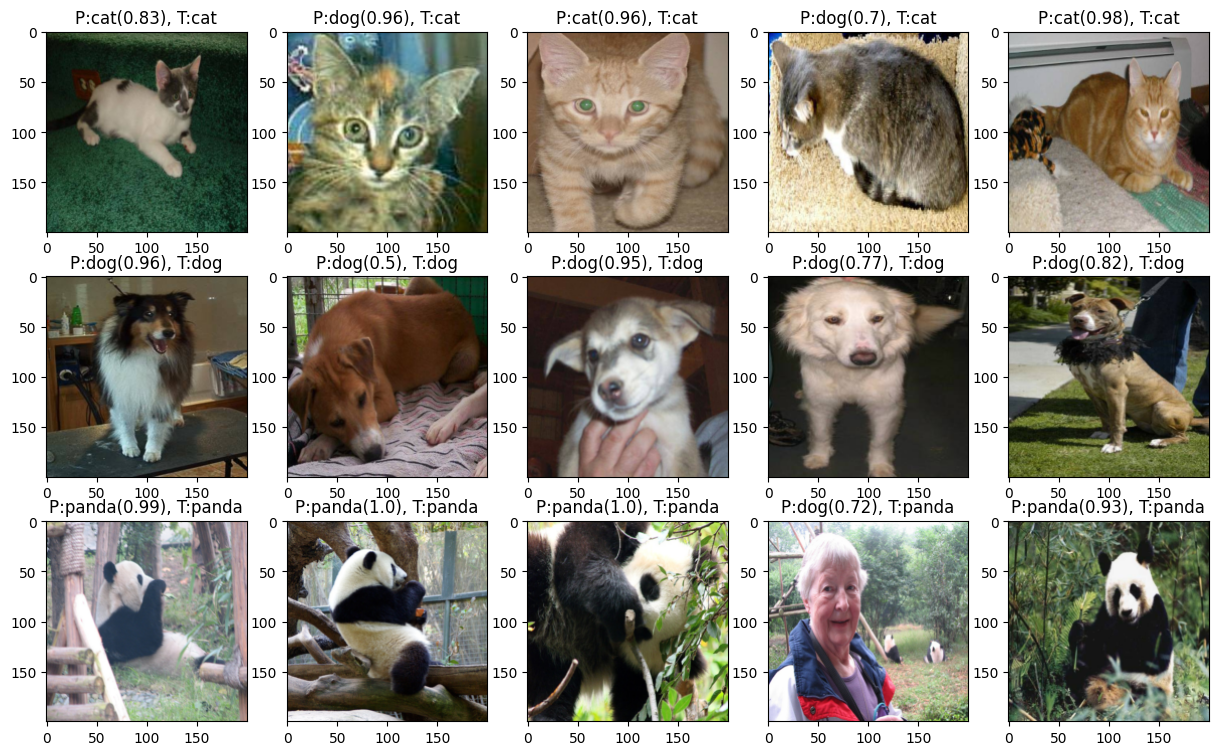

In [39]:
trained_model = MyModel()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)

train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")

mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)

get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

# Display Confusion Matrix.

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_root, img_size, mean, std):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)

    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


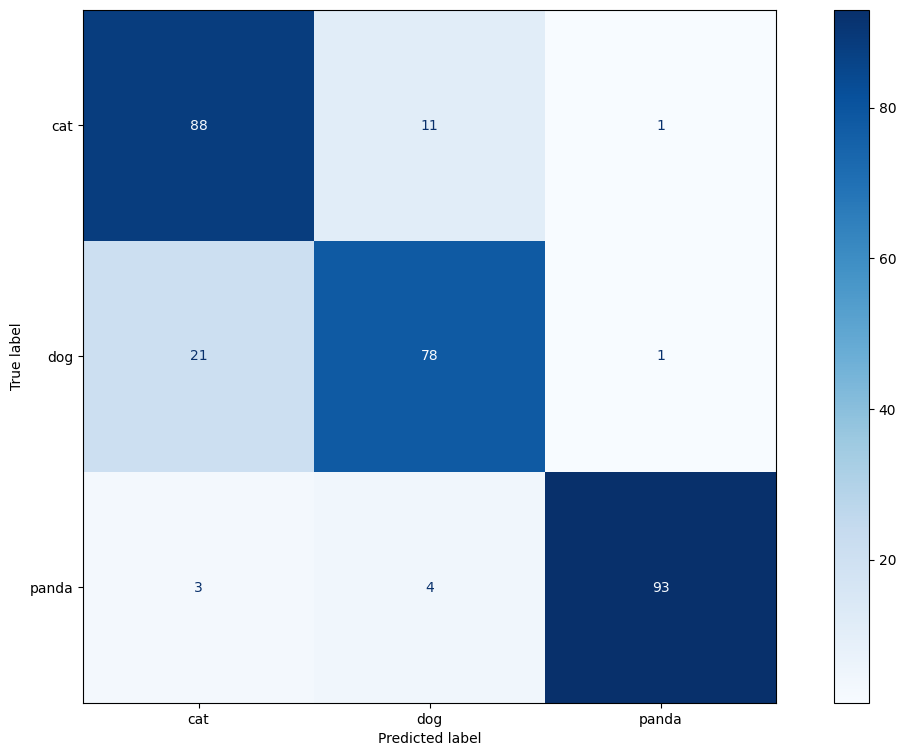

In [41]:
plot_confusion_matrix(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

## Generate Submission File.


**TASKS**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.

In [42]:
def generate_submission(model, test_dir, test_csv, img_size, mean, std, submission_csv="submission.csv"):
    import pandas as pd
    from torchvision import transforms, datasets
    import torch.nn.functional as F
    import torch
    from tqdm import tqdm
    import os

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    test_df = pd.read_csv(test_csv)

    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = datasets.ImageFolder(root="/kaggle/input/open-cv-py-torch-project-1-classification-round-2/dataset/Train")
    class_names = train_dataset.classes  # ['cat', 'dog', 'panda']

    predictions = []

    for img_id in tqdm(test_df["ID"]):
        img_path = os.path.join(test_dir, img_id)
        img = datasets.folder.default_loader(img_path)  # loads PIL image
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred_idx = output.argmax(dim=1).item()
        pred_class = class_names[pred_idx]
        predictions.append(pred_class)

    submission = pd.DataFrame({"ID": test_df["ID"], "CLASS": predictions})
    submission.to_csv(submission_csv, index=False)
    print(f"Submission saved as {submission_csv}")



In [43]:
generate_submission(
    trained_model,
    test_dir="/kaggle/input/open-cv-py-torch-project-1-classification-round-2/dataset/Test",
    test_csv="/kaggle/input/open-cv-py-torch-project-1-classification-round-2/test.csv",
    img_size=training_config.img_size,
    mean=mean,
    std=std,
    submission_csv="submission.csv"
)


100%|██████████| 600/600 [00:06<00:00, 88.10it/s]

Submission saved as submission.csv
